In [3]:
import auxiliary as aux
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as ssn
from math import exp
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Kohonen's self-organizing maps revisited
### In this notebook we are investigating the predictive power of such unsupervised learning

In [138]:
class Kohonen:

   def __init__(self, grid_shape: tuple, ndims: int, time_decay = float, verbose: bool=False, seed: float=42):
      self.sigma_init = 10
      self.alpha_init = 0.01
      self.data = None
      self.grid_shape = grid_shape
      self.ndims = ndims
      rng = np.random.default_rng(seed=seed)
      self.grid = rng.normal(loc=0.0, scale=1.0, size=grid_shape+(ndims,))
      self.rows = grid_shape[0]
      self.cols = grid_shape[1]
      self.population = np.zeros((self.rows, self.cols))
      self.labels = VariableArray3D(self.rows, self.cols)
      
      self.decay = time_decay
      self.time = 0
      self.step = 0.1
      self.verbose = verbose
      self.results = None
      self.means = None
      self.stds = None
      self.categories = None
      self.history = {"distances": [], "alpha": [], "sigma": []}

# Training methods

   def fit(self,data: np.array, epochs: int, shuffle: bool=False, labels: np.array=None):
      # check dimension compatibility
      data_shape = data.shape
      data_rows = data_shape[0]

      if data_shape[1] != self.ndims:
         print(f"Number of features ({data_shape[1]}) incompatible with grid height ({self.ndims})")
         return
      
      # Training loop
      if labels is not None:
         for j in tqdm(range(epochs)):
            if shuffle:
               np.random.shuffle(data)
            for i in range(data_rows):
               self.update(data[i,:], labels[i])
      else:
         for j in tqdm(range(epochs)):
            if shuffle:
               np.random.shuffle(data)
            for i in range(data_rows):
               self.update(data[i,:], None)

      return self.grid

   def update(self,candidate: np.array,label):
      """
      Called for each new presented sample during training
      Implements the update of the vectors in the grid
      """
      # Find the winning vector
      iw, jw, winner, min_distance = self.get_winner(candidate)
      # Save squared min distance for future analysis / monitoring of training
      self.history['distances'].append(min_distance)
      if self.verbose:      
         print("winner indices: ", iw, jw, "winner distance squared", min_distance)
      # Compute theta matrix
      theta_matrix = self.theta(iw,jw) 
      # Update alpha   
      alpha = self.alpha()
      # Save alpha to check history
      self.history['alpha'].append(alpha)
      # Compute increments for each vector
      increment = alpha * theta_matrix * (candidate - self.grid)
      # Update grid
      self.grid += increment
      # Update time
      self.time += self.step
      # Update population matrix
      self.population[iw,jw] += 1
      # Save feature value at winner grid coordinates
      if label is not None:
         self.labels.insert(iw,jw,label)
      return

   def get_winner(self,candidate) -> tuple:
      """
      Returns grid i, j indices of closest vector
      """
      distance_matrix = self.distance(candidate)
      iw, jw = np.unravel_index(np.argmin(distance_matrix), shape=(self.rows,self.cols))
      winner = self.grid[iw,jw]
      min_distance = distance_matrix[iw,jw]
      return iw, jw, winner, min_distance 

   def distance(self,candidate):
      """
      Compute the euclidean distances between each vector of the grid and the candidate vector
      Returns a matrix with grid shape
      """
      return np.sum((self.grid - candidate)**2, axis = 2)

   def theta(self, iw: int, jw: int):
      """
      Compute the matrix of theta used to update the vectors in the grid
      """
      # This can be optimized
      distance_2D = np.array([ [(i-iw)**2+(j-jw)**2 for j in range(self.cols)] for i in range(self.rows)])
      sigma = self.sigma()
      self.history['sigma'].append(sigma)
      theta_matrix = np.exp(-distance_2D**2 / (2*sigma))
      theta_matrix[np.isnan(theta_matrix)] = 0.0
      theta_matrix = theta_matrix.reshape((self.rows,self.cols,1))
      return np.repeat(theta_matrix,self.ndims, axis = 2)

   def sigma(self):
      """
      Compute the current sigma parameter
      """
      return self.sigma_init * exp(-self.time / self.decay)

   def alpha(self):
      """
      Compute the current alpha parameter
      """      
      alpha = self.alpha_init * exp(-self.time / self.decay)
      if alpha is not np.nan:
         return alpha
      else:
         return 0

# Prediction methods

   def predict_reg(self, data):
      """
      Makes prediction in regression case
      Returns the means and standard deviations of features for each data sample
      """
      
      if self.labels == None:
         print("Unassigned labels, fit data with features first")
         return

      self.results = None

      labels_means = np.empty((len(data),1))      
      labels_stds = np.empty((len(data),1))

      # Compute mean and std
      self.means = self.labels.mean()
      self.stds = self.labels.std()

      # Fill in the grid assignment into self.results
      self.assign(data)

      # Retrieve means and std from grid of means and standard deviations
      for k in range(len(data)):
         labels_means[k,0] = self.means[self.results[k][0], self.results[k][1]]
         labels_stds[k,0] = self.stds[self.results[k][0], self.results[k][1]]

      return labels_means, labels_stds      
   
   def predict_clf(self, data):
      """
      Makes prediction in classification case
      Returns the most frequent class for each data sample
      """

      if self.labels == None:
         print("Unassigned labels, fit data with labels first")
         return

      self.results = None

      labels_cat = np.empty((len(data),1))

      self.categories = self.labels.category(mode='frequency')

      self.assign(data)

      for k in range(len(data)):
         labels_cat[k,0] = self.categories[self.results[k][0], self.results[k][1]]

      return labels_cat
   
   def assign(self, data):
      """
      Returns grid indices of vectors closest to data
      """
      data_shape = data.shape
      data_rows = data_shape[0]

      if data_shape[1] != self.ndims:
         print(f"Number of features ({data_shape[1]}) incompatible with grid height ({self.ndims})")
         return

      results = np.empty((data_rows,2))

      # This could be vectorized
      for i in range(data_rows):
         results[i,0], results[i,1], _, _ = self.get_winner(data[i,:])

      self.results = results.astype(int)

      return self.results

   def reset_predictions(self):
      self.results = None

# Plots

   def plot_assignment(self):
      """
      Plots where the prediction fell into the grid
      """
      result_grid = np.zeros((self.rows,self.cols))
      if self.results is not None:
         for i, res in enumerate(self.results):
                 result_grid[res[0],res[1]] += 1
         plt.imshow(result_grid)
         return result_grid
      else:
         print("Run fit() first")
         return

   def plot_parameters(self):
      """
      Plots the evolution of distances, alpha and sigma during training
      """
      fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 10), nrows=3)
      ax1.plot(self.history['distances'])
      ax1.set_title('distances')
      ax2.plot(self.history['alpha'])
      ax2.set_title('alpha')
      ax3.plot(self.history['sigma'])
      ax3.set_title('sigma')

# Helper class to store predicted labels/features in a grid with variable size 3rd dimension
# as we do not know in advance where the presented data will be assigned in the grid

class VariableArray3D:

   def __init__(self, rows: int, cols: int):
      self.rows = rows
      self.cols = cols
      # Variable array as a fixed size list of fixed size list of variable size list
      self.array = [[[] for col in range(cols)] for row in range(rows)]

   def insert(self, row: int, col: int, value: float):
      """
      Inserts a value in the array      
      """
      self.array[row][col].append(value)
      return self.array

   def mean(self):
      """
      Computes the mean of features at each point i, j of the grid
      For regression problems
      """
      mean_array = np.zeros((self.rows,self.cols))
      for i in range(self.rows):
         for j in range(self.cols):
            if len(self.array[i][j]) > 0:
               mean_array[i,j] = np.mean(np.array(self.array[i][j]))
            else:
               mean_array[i,j] = 0.0
      return mean_array

   def std(self):
      """
      Computes the standard deviations of features at each point i, j of the grid
      For regression problems
      """
      std_array =  np.zeros((self.rows,self.cols))
      for i in range(self.rows) :
         for j in range(self.cols):
            if len(self.array[i][j]) > 0:
               std_array[i,j] = np.std(np.array(self.array[i][j]))
            else:
               std_array[i,j] = 0.0
      return std_array

   def count(self):
      """
      Counts non null values in the 3D array      
      """
      count_array = np.zeros((self.rows,self.cols))
      for i in range(self.rows):
         for j in range(self.cols):
            count_array[i,j] = np.count_nonzero(np.array(self.array[i][j]))
      return count_array

   def category(self, mode: str='frequency'):
      """
      Computes the most likely class at each point i,j of the grid
      For classification problems
      Only one method implemented, returning the most frequent class found
      """

      category_array =  np.zeros((self.rows,self.cols))

      if mode == 'frequency':
         for i in range(self.rows) :
            for j in range(self.cols):
               if len(self.array[i][j]) > 0:
                  bincount = np.bincount(np.array(self.array[i][j]).astype(int))
                  category_array[i,j] = np.argmax(bincount)
               else:
                  category_array[i,j] = -1
      return category_array

   def get_vector(self,row: int, col: int):
      """
      Returns the 3rd dimension of the 3D array as a list
      """
      return self.array[row][col]

   def plot_dominant(self, discrete = True):
      """
      Plots either the most frequent value or the mean of the values in array
      """
      grid_to_plot = np.zeros((self.rows, self.cols))
      if discrete:
         for i in range(self.rows):
            for j in range(self.cols):
               if len(self.array[i][j]) > 0:
                  bincount = np.bincount(np.array(self.array[i][j]).astype(int))
                  grid_to_plot[i,j] = np.argmax(bincount)
               else:
                  grid_to_plot[i,j] = -1
      else:
         for i in range(self.rows):
            for j in range(self.cols):
               if len(self.array[i][j]) > 0:
                  grid_to_plot[i,j] = np.mean(np.array(self.array[i][j]))
               else:
                  grid_to_plot[i,j] = 0.0
      
      plt.imshow(grid_to_plot)
      plt.title("Dominant values")


## Example 1 - no labels
### Can it learn to recognize unit vectors and their opposites?

In [11]:
# Create sample with 3D vectors
example_1 = Kohonen((5,5),3,1,False)
data_1 = np.concatenate((np.eye(3), -np.eye(3)), axis = 0)

100%|██████████| 100/100 [00:00<00:00, 836.16it/s]


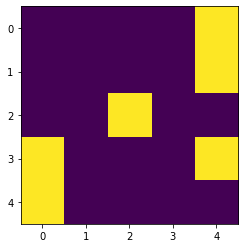

array([[  0.,   0.,   0.,   0., 300.],
       [  0.,   0.,   0.,   0., 300.],
       [  0.,   0., 300.,   0.,   0.],
       [300.,   0.,   0.,   0., 300.],
       [300.,   0.,   0.,   0.,   0.]])

In [14]:
# Train the grid
output = example_1.fit(data_1,100, shuffle=True)

plt.imshow(example_1.population)
plt.show()
example_1.population

The 6 vectors have each been assigned to a particular region of the grid. It only took 10 epochs.

Now let's make some predictions

In [26]:
# Create some data with and without noise
X_test = np.array([[0,0,0.5],[0,-0.5,0],[0,0,1], [0,-1,0],[0,0,-1], [0.1,-0.2,1], [0.5, 0.4, -0.6]])

res = example_1.assign(X_test)

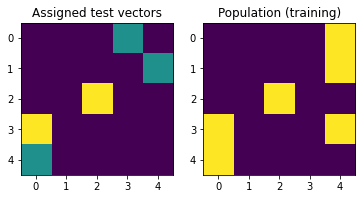

In [27]:
plt.subplot(1,2,1)
plt.title("Assigned test vectors")
example_1.plot_assignment()
plt.subplot(1,2,2)
plt.title("Population (training)")
plt.imshow(example_1.population)
plt.show()

## Example 2 - no labels
### 2 overlapping populations of random vectors

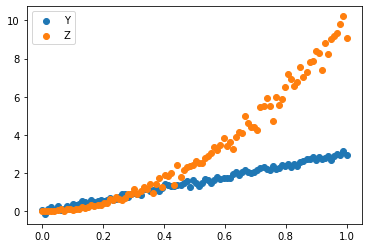

In [90]:
# Make training data
noise_1 = np.random.normal(scale = 0.1, size=(100,))
noise_2 = np.random.normal(scale = 0.5, size=(100,))
X = np.linspace(0,1,100)
Y = 3*X + noise_1
Z = 10*X**2 + noise_2*X
plt.scatter(X,Y)
plt.scatter(X,Z)
plt.legend(['Y', 'Z'])
plt.show()

XY = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)), axis = 1)
XZ = np.concatenate((X.reshape(-1,1),Z.reshape(-1,1)), axis = 1)
data_2 = np.concatenate((XY,XZ), axis = 0)


In [91]:
# Instantiate model
example_2 = Kohonen((10,10),2,100,False)

100%|██████████| 100/100 [00:04<00:00, 22.36it/s]


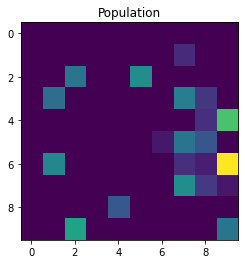

In [92]:
# Train the grid
output = example_2.fit(data_2,100,True)

plt.imshow(example_2.population)
plt.title('Population')
plt.show()

In [93]:
# Make test data
noise_3 = np.random.normal(scale = 0.1, size=(10,))
noise_4 = np.random.normal(scale = 0.5, size=(10,))
Y_test = 3*X + noise_1
Z_test = 10*X**2 + noise_2*X
XY_test = np.concatenate((X.reshape(-1,1),Y_test.reshape(-1,1)), axis = 1)
XZ_test = np.concatenate((X.reshape(-1,1),Z_test.reshape(-1,1)), axis = 1)
data_2_test = np.concatenate((XY_test,XZ_test), axis = 0)
# Assign test data to the grid
res = example_2.assign(data_2_test)

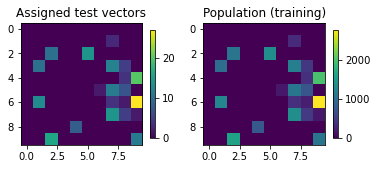

In [95]:
plt.subplot(1,2,1)
plt.title("Assigned test vectors")
example_2.plot_assignment()
plt.colorbar(shrink=0.5)
plt.subplot(1,2,2)
plt.title("Population (training)")
plt.imshow(example_2.population)
plt.colorbar(shrink=0.5)
plt.show()

## Example 2 extended - with labels
### 2 overlapping populations of random vectors with corresponding labels

In [116]:
# Add labels to training data
Y_labels = np.ones(shape=(len(XY),))
Z_labels = 2*Y_labels
labels = np.concatenate((Y_labels, Z_labels), axis = 0)

In [139]:
# Reinstantiate model and train with labels
example_2 = Kohonen((10,10),2,100,False)

output = example_2.fit(data_2,100,True,labels=labels)

100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


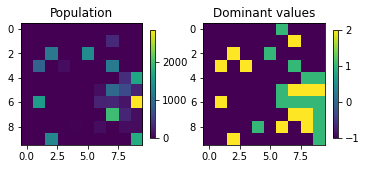

In [141]:
plt.subplot(1,2,1)
plt.imshow(example_2.population)
plt.title('Population')
plt.colorbar(shrink=0.5)
plt.subplot(1,2,2)
example_2.labels.plot_dominant(True)
plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Add labels to test data


### Test avec labels

100%|██████████| 200/200 [00:10<00:00, 19.82it/s]


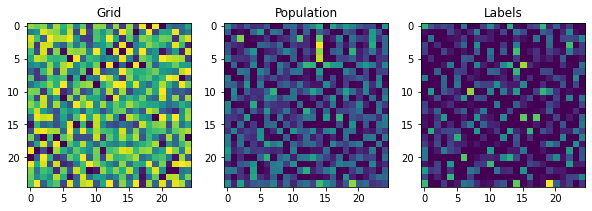

In [53]:
example3 = np.random.normal(size=(50,3))
labels = np.random.randint(0,2,size=50).reshape((50,1))

kiki = Kohonen((25,25),3,200,False)

output = kiki.fit(example2,200, labels=labels)
output_norm = np.linalg.norm(output, axis=2)
scaler = MinMaxScaler(feature_range=(0,255))
output_scaled = scaler.fit_transform(output_norm).astype(int)
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(output_scaled)
plt.title('Grid')
plt.subplot(1,3,2)
plt.imshow(kiki.population)
plt.title('Population')
plt.subplot(1,3,3)
plt.imshow(kiki.labels.count())
plt.title('Labels')
plt.show()

In [201]:
def make_sample_regression(size: int, deviation: float=1):
   M = np.eye(3)
   sample = np.empty((size,4))
   labels = {0: 1, 1: 3, 2: -1}

   for i in range(size):
      pick = np.random.randint(0,3)
      sample[i,:3] = M[pick]
      noise = np.random.normal(loc=0, scale=deviation)
      sample[i,3] = labels[pick] + noise

   return sample

## Example 4 Training

In [182]:
example4 = make_sample_regression(100,0.1)

kuku = Kohonen((10,10),3,100,verbose=False)
output = kuku.fit(example4[:,:3],100,False,example4[:,3])
output_norm = np.linalg.norm(output, axis=2)
scaler = MinMaxScaler(feature_range=(0,255))
output_scaled = scaler.fit_transform(output_norm).astype(int)

100%|██████████| 100/100 [00:02<00:00, 42.43it/s]


Text(0.5, 1.0, 'sigma')

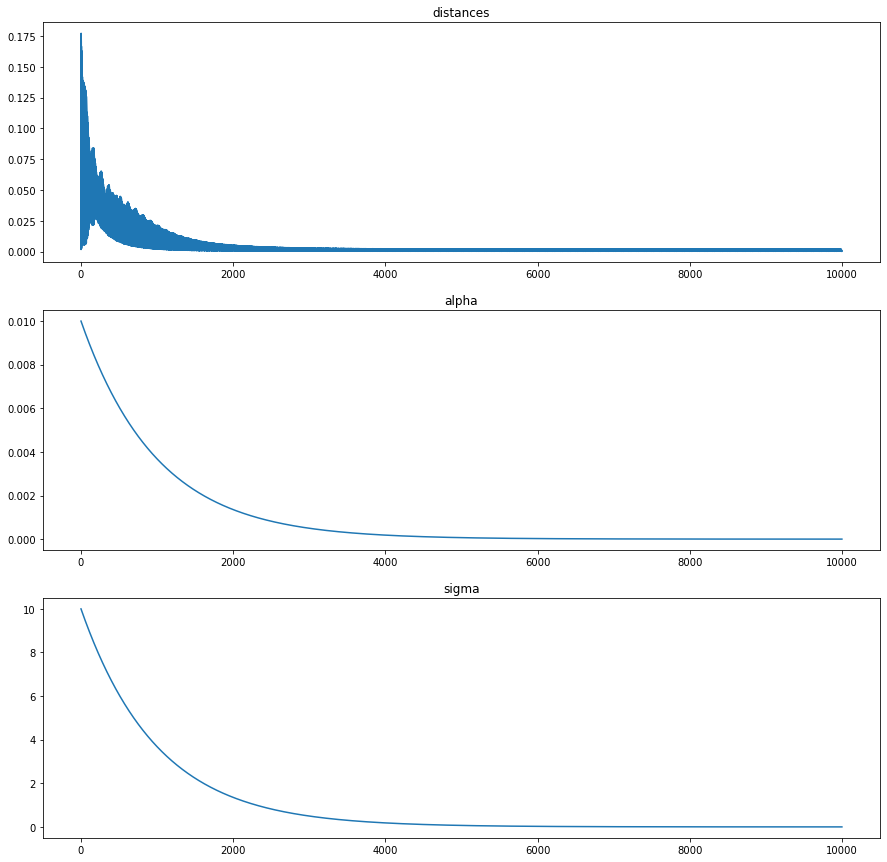

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 15), nrows=3)
ax1.plot(kuku.history['distances'])
ax1.set_title('distances')
ax2.plot(kuku.history['alpha'])
ax2.set_title('alpha')
ax3.plot(kuku.history['sigma'])
ax3.set_title('sigma')

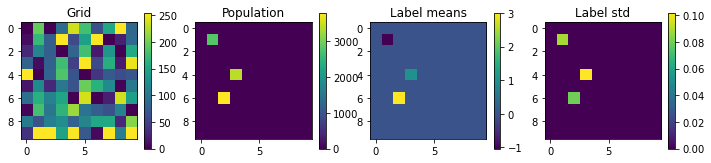

In [184]:
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)

plt.imshow(output_scaled)
plt.colorbar(shrink=0.5)
plt.title('Grid')
plt.subplot(1,4,2)

plt.imshow(kuku.population)
plt.title('Population')
plt.colorbar(shrink=0.5)
plt.subplot(1,4,3)

plt.imshow(kuku.labels.mean())
plt.title('Label means')
plt.colorbar(shrink=0.5)
plt.subplot(1,4,4)

plt.imshow(kuku.labels.std())
plt.title('Label std')
plt.colorbar(shrink=0.5)
plt.show()

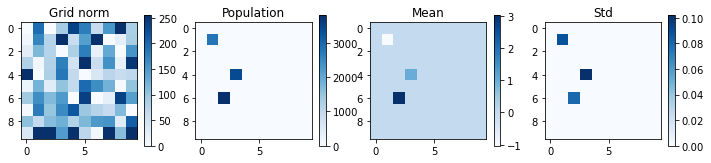

In [185]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 6), ncols=4)
grid = ax1.imshow(output_scaled, cmap='Blues', interpolation='none')
ax1.set_title('Grid norm')
fig.colorbar(grid, ax=ax1, shrink=0.4)

population = ax2.imshow(kuku.population, cmap='Blues', interpolation='none')
ax2.set_title('Population')
fig.colorbar(population, ax=ax2, shrink=0.4)

mean = ax3.imshow(kuku.labels.mean(), cmap='Blues', interpolation='none')
ax3.set_title('Mean')
fig.colorbar(mean, ax=ax3, shrink=0.4)

std = ax4.imshow(kuku.labels.std(), cmap='Blues', interpolation='none')
ax4.set_title('Std')
fig.colorbar(std, ax=ax4, shrink=0.4)

plt.show()

[[4 3]]
[[6 2]]
[[1 1]]


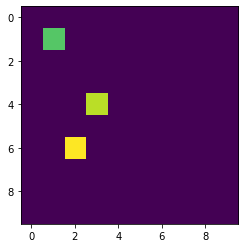

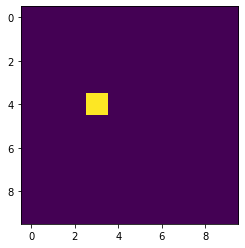

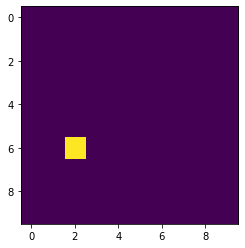

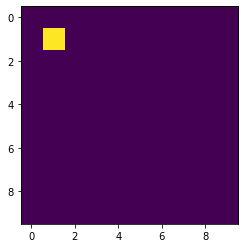

[1.0084845718083555, 3.0123772412709497, -1.033877150595477]
[0.10195729212448151, 0.07994858064458464, 0.08803446973560244]


In [186]:
test_sample = make_sample_regression(100,0)

M = np.eye(3)
N = np.array([1,3,-1]).reshape((3,1))
P = np.concatenate((M,N),axis = 1)

means = []
stds = []

plt.figure()
plt.imshow(kuku.population)
res = kuku.assign(M[0].reshape((1,3)))
print(res)
means.append(kuku.labels.mean()[res[0][0],res[0][1]])
stds.append(kuku.labels.std()[res[0][0],res[0][1]])
plt.figure()
kuku.plot_assignment()
res = kuku.assign(M[1].reshape((1,3)))
print(res)
means.append(kuku.labels.mean()[res[0][0],res[0][1]])
stds.append(kuku.labels.std()[res[0][0],res[0][1]])
plt.figure()
kuku.plot_assignment()
res = kuku.assign(M[2].reshape((1,3)))
print(res)
means.append(kuku.labels.mean()[res[0][0],res[0][1]])
stds.append(kuku.labels.std()[res[0][0],res[0][1]])
plt.figure()
kuku.plot_assignment()
plt.show()

print(means)
print(stds)


## Example 4 regression

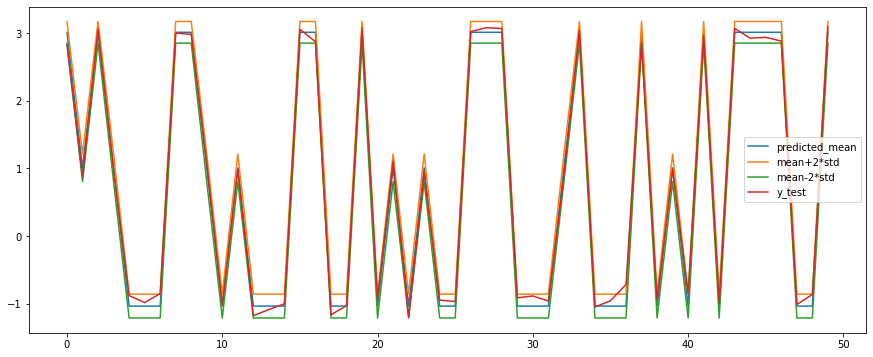

In [191]:
X_test = make_sample_regression(50,0.1)

preds_mean, preds_std = kuku.predict_reg(X_test[:,:3])
y_test = X_test[:,3]

plt.figure(figsize=(15,6))
plt.plot(preds_mean)
plt.plot(preds_mean+2*preds_std)
plt.plot(preds_mean-2*preds_std)
plt.plot(y_test)
plt.legend(['predicted_mean', 'mean+2*std', 'mean-2*std', 'y_test'])


## Example 5 Classification

In [234]:
def make_sample_classification(size: int, bias: float=0.0, deviation: float=1):
   M = np.random.normal(scale=deviation,size=(size,3))
   sample = np.empty((size,4))
   labels = {0: 1, 1: 2, 2: 3, 3: 4,4: 5, 5: 6, 6: 7, 7: 8}
   bias = 0.0

   for i in range(size):
      sample[i,:3] = M[i]
      category = 4*int(M[i,0] > bias) + 2*int(M[i,1] > bias) + int(M[i,2] > bias)
      sample[i,3] = int(labels[category])


   return sample

In [256]:
example5 = make_sample_classification(2500,0.01, 1.0)

time_decay = 10000

keke = Kohonen((30,30),3,time_decay,verbose=False)

output = keke.fit(example5[:,:3],200,False,example5[:,3])

100%|██████████| 200/200 [10:16<00:00,  3.08s/it]


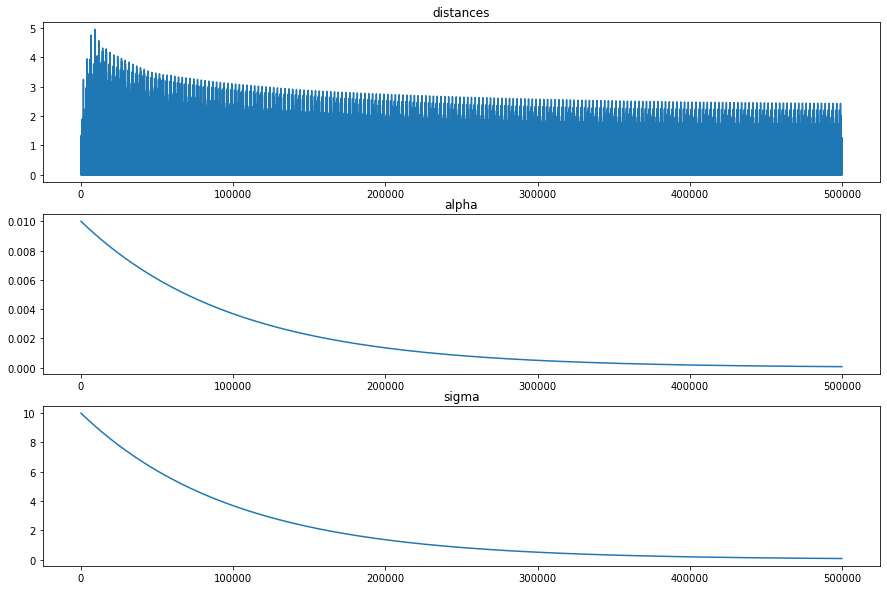

In [257]:
keke.plot_parameters()

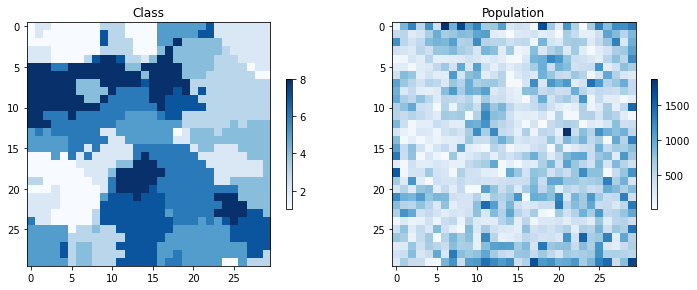

In [258]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)

class_ = ax1.imshow(keke.labels.category(), cmap='Blues', interpolation='none')
ax1.set_title('Class')
fig.colorbar(class_, ax=ax1, shrink=0.4)

population = ax2.imshow(keke.population, cmap='Blues', interpolation='none')
ax2.set_title('Population')
fig.colorbar(population, ax=ax2, shrink=0.4)

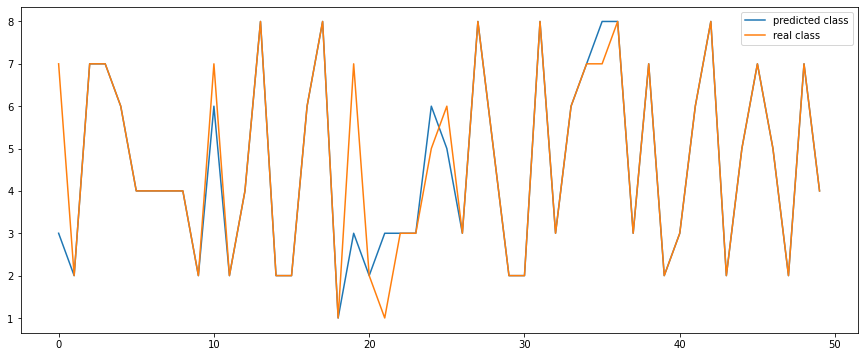

In [259]:
X_test = make_sample_classification(50,0.01,1)

preds_cat = keke.predict_clf(X_test[:,:3])
y_test = X_test[:,3]

plt.figure(figsize=(15,6))
plt.plot(preds_cat)
plt.plot(y_test)
plt.legend(['predicted class', 'real class'])
plt.show()

# Real data tests

### Iris classification

In [261]:
# Charger les datas
# Normaliser les features
data = pd.read_csv("IRIS.csv")

In [268]:
data['categories'] = pd.Categorical(data.species)

In [270]:
data['codes'] = data['categories'].cat.codes

In [271]:
data

,sepal_length,sepal_width,petal_length,petal_width,species,categories,codes
0,5.1,3.5,1.4,0.2,Iris-setosa,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,Iris-setosa,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,Iris-virginica,2


In [272]:
data_selected = data.drop(columns=['species', 'categories'])

In [280]:
data['codes'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [287]:
model_iris = Kohonen((5,5),4,50,False)

X_train, X_test, y_train, y_test = train_test_split(data_selected.iloc[:,:4].values, data['codes'].values, test_size = 0.2, shuffle=True)

grid_iris = model_iris.fit(X_train, 100,False,y_train)

100%|██████████| 100/100 [00:01<00:00, 64.03it/s]


In [288]:
preds_iris = model_iris.predict_clf(X_test)

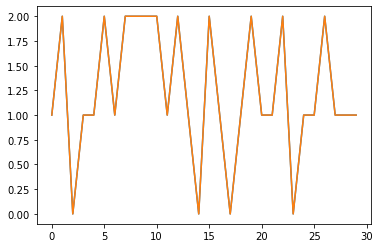

In [289]:
plt.plot(preds_iris)
plt.plot(y_test)

In [285]:

def plot_categories(model):
   fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)

   class_ = ax1.imshow(model.labels.category(), cmap='Blues', interpolation='none')
   ax1.set_title('Class')
   fig.colorbar(class_, ax=ax1, shrink=0.4)

   population = ax2.imshow(model.population, cmap='Blues', interpolation='none')
   ax2.set_title('Population')
   fig.colorbar(population, ax=ax2, shrink=0.4)

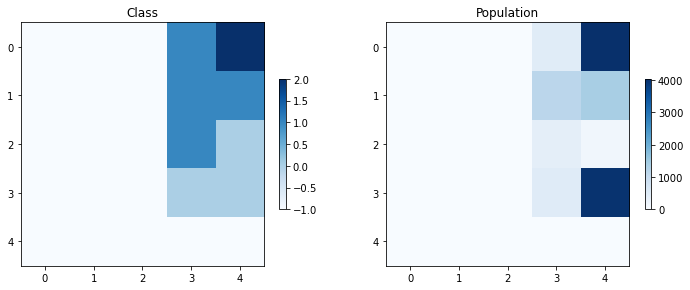

In [290]:
plot_categories(model_iris)

### House price regression

In [147]:
data = pd.read_csv('./house_prices/train.csv')

In [148]:
# Replace categories by integers
data_cat = data.copy()

num_cols = []

for col in data_cat.columns:
   if data_cat.dtypes[col].type not in [np.int64, np.float64]:
      data_cat[col] = data_cat[col].astype("category").cat.codes
   else:
      num_cols.append(col)

data_cat.head()
num_cols.remove('Id')
num_cols.remove('SalePrice')

In [149]:
y = data_cat.SalePrice
data_cat.drop(columns=['Id','SalePrice'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_cat, y, test_size = 0.1, shuffle=True)

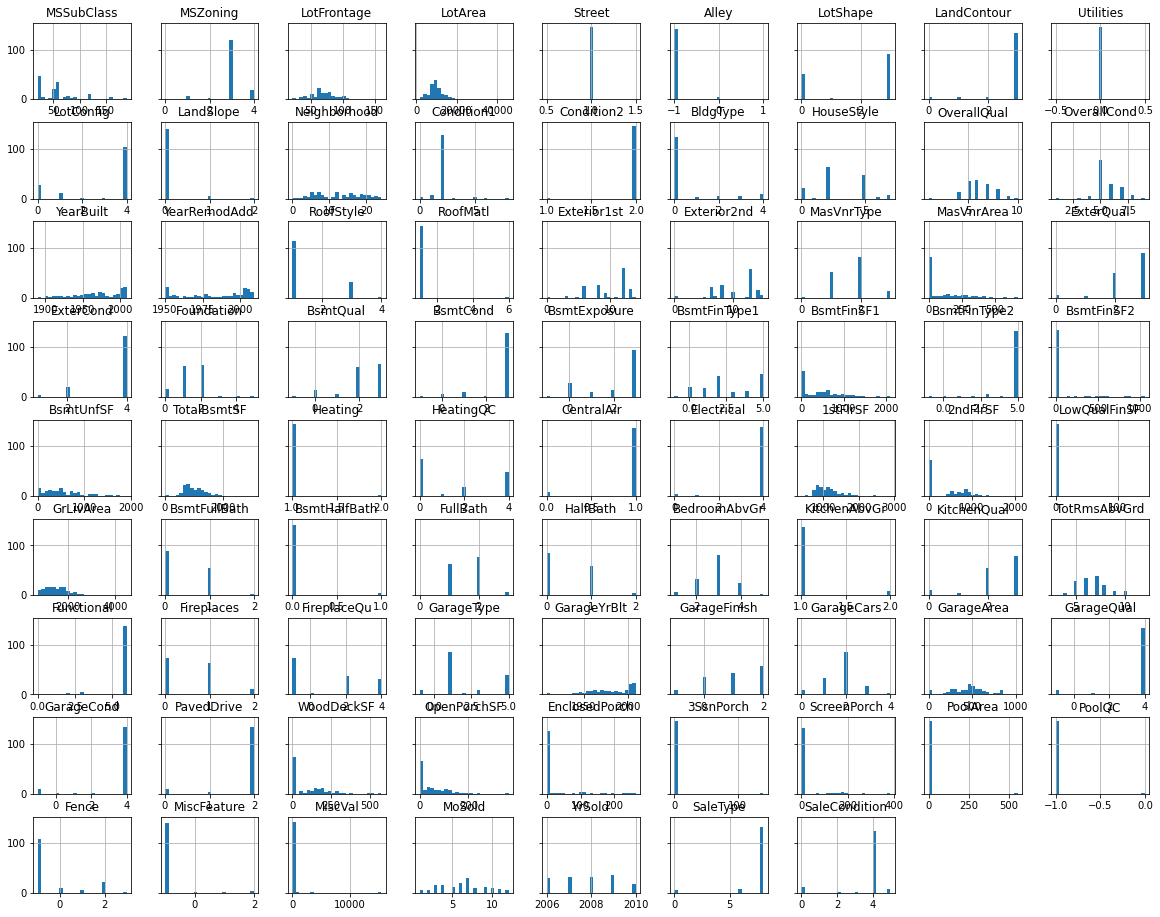

In [150]:
X_test.hist(figsize=(20,16),bins = 25, sharey=True, )
plt.show()

In [152]:
scaling_dict = {'Minmax': num_cols }
X_train, X_test = aux.scaling(scaling_dict,X_train,[X_test])
X_test = X_test[0]
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

In [212]:
ensemble_houses = KohonenEnsemble(20,10)

In [213]:
ensemble_houses.fit(X_train,20,False,y_train)

Min dim: 1, max dim: 7
Grid size: 11
Grid size min: 6, grid size max: 16


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


In [214]:
res = ensemble_houses.predict_reg(X_test.iloc[9:10,:])

In [215]:
y_test.iloc[9]

8.8

In [216]:
res

[[11.445, 3.708163291981625],
 [12.835714285714285, 4.897901466496667],
 [16.28684210526316, 8.306491998789047],
 [13.712934631432546, 4.423321319913804],
 [23.100000000000005, 3.552713678800501e-15],
 [13.94, 4.37154434954056],
 [22.148886725879063, 8.846559113085945],
 [9.711764705882352, 3.7175074433947675],
 [14.892307692307693, 5.787448160719692],
 [12.65090909090909, 4.588201181579185],
 [12.425917602996254, 4.159898015436041],
 [8.399999999999999, 1.6753109164172086],
 [13.61012658227848, 6.492382974905106],
 [8.1, 0.0],
 [11.502684563758388, 4.60618851751524],
 [17.02777777777778, 3.9225566429669247],
 [15.474766355140186, 7.115562691877965],
 [14.280392156862746, 5.2621109462761115],
 [15.552173913043479, 9.112049813068476],
 [12.113039723661485, 4.241251597395711]]

##### Kohonen alone does not work

In [85]:
model_house = Kohonen((30,30),79,1000,False)

In [86]:
model_house.fit(X_train.values,300,shuffle=True,labels=y_train.values)
0

100%|██████████| 300/300 [10:38<00:00,  2.13s/it]


0

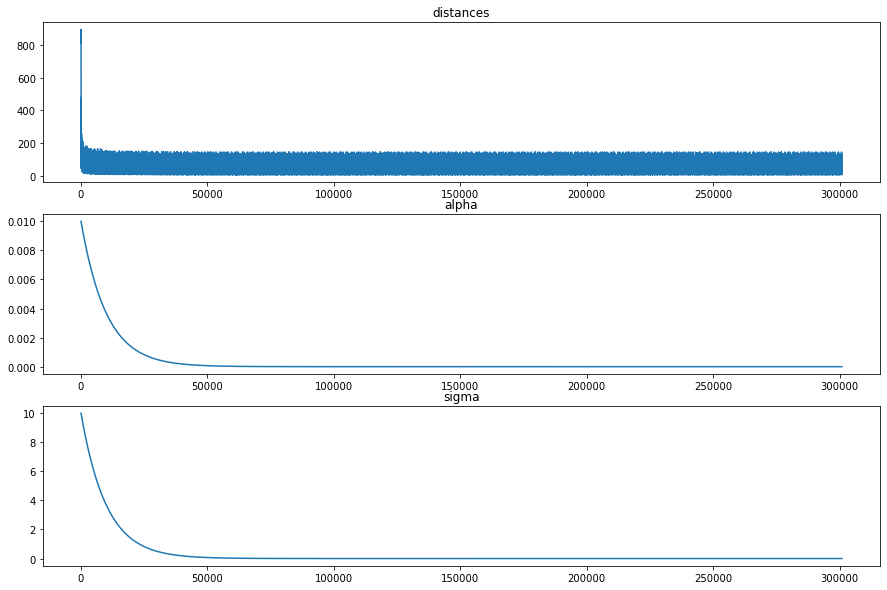

In [87]:
model_house.plot_parameters()

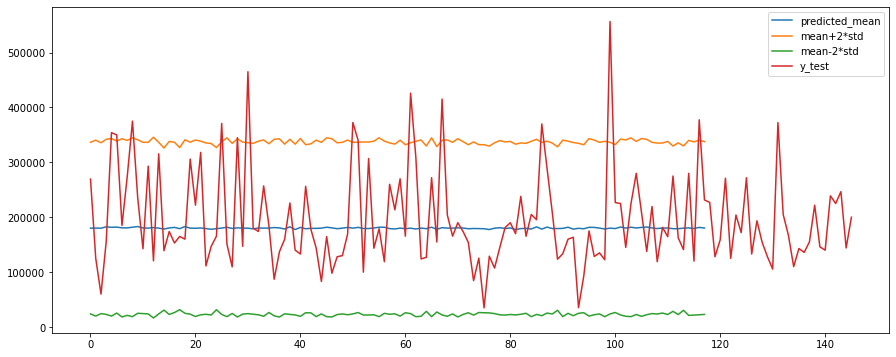

In [95]:
preds_mean, preds_std = model_house.predict_reg(X_test.values)

plt.figure(figsize=(15,6))
plt.plot(preds_mean)
plt.plot(preds_mean+2*preds_std)
plt.plot(preds_mean-2*preds_std)
plt.plot(y_test.values)
plt.legend(['predicted_mean', 'mean+2*std', 'mean-2*std', 'y_test'])

### House price regression (Boston)

In [7]:
data = pd.read_csv('./house_prices/boston.csv')

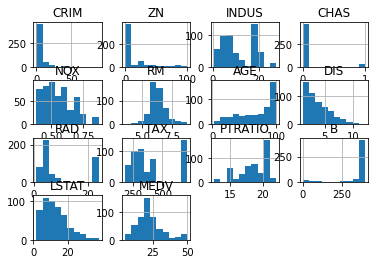

In [8]:
data.hist()
plt.show()

In [9]:
# Replace string categories by integers
data_cat = data.copy()

num_cols = []

for col in data_cat.columns:
   if data_cat.dtypes[col].type not in [np.int64, np.float64]:
      data_cat[col] = data_cat[col].astype("category").cat.codes
   else:
      num_cols.append(col)

data_cat.head()
# Remove target column from column list
num_cols.remove('MEDV')

In [10]:
y = data_cat.MEDV
data_cat.drop(columns=['MEDV'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_cat, y, test_size = 0.1, shuffle=True)

In [11]:
# Normalize
scaling_dict = {'Power': num_cols }
X_train, X_test = aux.scaling(scaling_dict,X_train,[X_test])
X_test = X_test[0]
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

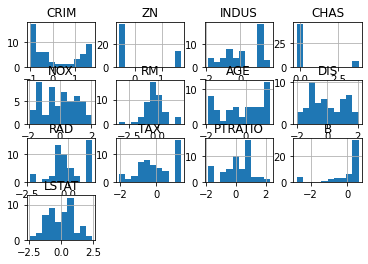

In [12]:
X_test.hist()
plt.show()

In [36]:
ensemble_boston = KohonenEnsemble(20,30)

In [37]:
ensemble_boston.fit(X_train,20,False,y_train)

Generating ensemble of models
13 dimensions detected
Min dim: 1, max dim: 7
Grid size: 11
Grid size min: 6, grid size max: 16
Model: 0


100%|██████████| 20/20 [00:03<00:00,  5.12it/s]


Model: 1


100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Model: 2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Model: 3


100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


Model: 4


100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


Model: 5


100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


Model: 6


100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Model: 7


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Model: 8


100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Model: 9


100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Model: 10


100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Model: 11


100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


Model: 12


100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


Model: 13


100%|██████████| 20/20 [00:01<00:00, 10.77it/s]


Model: 14


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


Model: 15


100%|██████████| 20/20 [00:01<00:00, 10.85it/s]


Model: 16


100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Model: 17


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Model: 18


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Model: 19


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


In [122]:
init = 0
end = 50

preds, preds_std = ensemble_boston.aggregate("regression", X_test[init:end])
print(y_test[init:end])
print(preds)
print(preds_std)

432    16.1
234    29.0
212    22.4
450    13.4
351    24.1
285    22.0
192    36.4
441    17.1
246    24.3
446    14.9
91     22.0
396    12.5
32     13.2
377    13.3
423    13.4
258    36.0
384     8.8
458    14.9
98     43.8
196    33.3
67     22.0
297    20.3
49     19.4
407    27.9
491    13.6
349    26.6
489     7.0
316    17.8
141    14.4
413    16.3
215    25.0
284    32.2
56     24.7
240    22.0
51     20.5
97     38.7
418     8.8
380    10.4
33     13.1
132    23.0
355    20.6
218    21.5
9      18.9
201    24.1
10     15.0
62     22.2
228    46.7
69     20.9
230    24.3
463    20.2
Name: MEDV, dtype: float64
[[18.6       ]
 [27.05343355]
 [21.07098153]
 [15.35415517]
 [20.75384615]
 [21.9       ]
 [29.78557614]
 [14.718835  ]
 [23.13417097]
 [15.44003507]
 [24.9568025 ]
 [14.38518149]
 [16.79114048]
 [13.37717172]
 [14.5303079 ]
 [28.980777  ]
 [13.25140897]
 [15.18035219]
 [32.01038579]
 [34.6       ]
 [23.03855349]
 [21.7       ]
 [14.4       ]
 [16.7       ]
 [20.1       

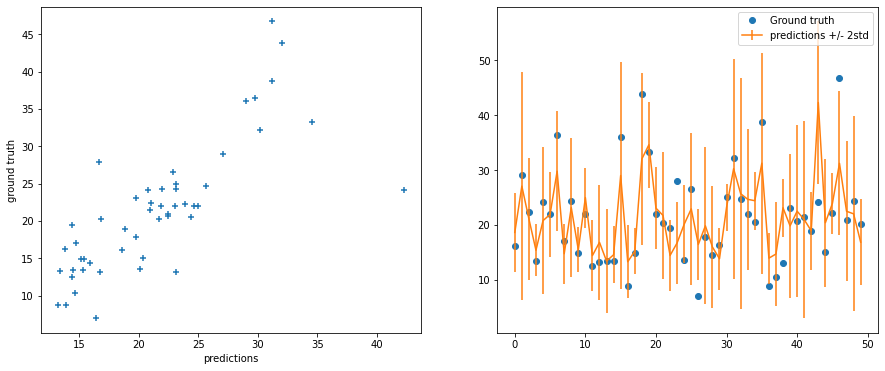

29.82575023758255

In [125]:
ensemble_boston.plot_pred_y(y_test[init:end],preds,preds_std)
ensemble_boston.rmse(y_test[init:end],preds)

In [ ]:
init = 10
end = 15
res, params = ensemble_boston.predict_reg(X_test.iloc[init:end,:])

for i in range(len(res)):
   print(res[i])
   print(params[i])

In [236]:
res_arr = np.array(res)
np.mean(res_arr, axis = 0)

array([16.89720087,  5.20279991])

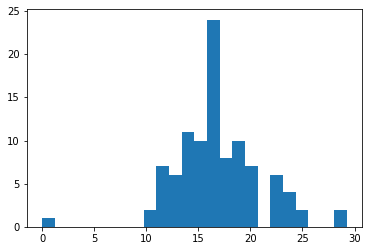

In [235]:
plt.hist(res_arr[:,0], bins=24)
plt.show()

(array([ 8., 10., 17., 30., 35., 39., 76., 63., 65., 11., 21., 18., 14.,
        12.,  6.,  1.,  5.,  4.,  1., 19.]),
 array([ 5.  ,  7.25,  9.5 , 11.75, 14.  , 16.25, 18.5 , 20.75, 23.  ,
        25.25, 27.5 , 29.75, 32.  , 34.25, 36.5 , 38.75, 41.  , 43.25,
        45.5 , 47.75, 50.  ]),
 <BarContainer object of 20 artists>)

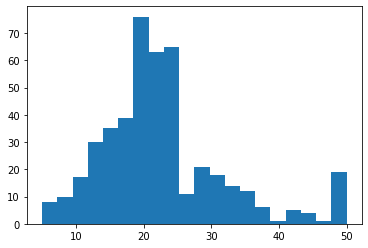

In [62]:
plt.hist(y_train, bins=20)